## Timeseries demo




In [1]:
import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np
tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/'
tsvProxy = "https://viewer.integration.terrascope.be/proxy/timeseries/v1.0/ts/" #is the same as the one above
response = requests.get(tsvBaseURL)



In [2]:
if response.status_code == 200:
    layerlist = response.json()['layers']
else:
    raise IOError(response.text)


let's investigate the layers that are offered.

In [3]:
count=0
for l in layerlist:
    if len(l['dates'])>0:
        count=count+1
        if '[UTC]' in l['dates'][0]:
            print(l['name'].ljust(40), '{0:4d} '.format(len(l['dates'])), min(l['dates'])[:-5], 'to', max(l['dates'])[:-5])
        else:
            print(l['name'].ljust(40), '{0:4d} '.format(len(l['dates'])), min(l['dates']), 'to', max(l['dates']))
print(">>>", count, 'layers with data')
print('Layers with no dates')
count=0
for l in layerlist:
    if len(l['dates'])==0:
        count=count+1
        print(l['name'])
print(">>>", count, 'layers without data')


DCS4COP_FLANDERS_TUR_L8                   159  2017-01-03T10:40:38Z to 2018-08-27T10:33:22Z
DCS4COP_FLANDERS_TUR                      454  2017-01-02T11:14:42Z to 2018-10-31T11:02:01Z
DCS4COP_NDAVI_V103                          4  2020-05-29T11:21:21Z to 2020-05-30T12:27:01Z
S1_GRD_GAMMA0_DESCENDING_ANGLE           1043  2015-01-07T00:00:00Z to 2020-06-15T00:00:00Z
S2_FAPAR_V102_WEBMERCATOR2                595  2015-07-06T00:00:00Z to 2018-10-10T00:00:00Z
S1_GRD_SIGMA0_DESCENDING_VH              1043  2015-01-07T00:00:00Z to 2020-06-15T00:00:00Z
TERRASCOPE_S1_SLC_COHERENCE_V1_VH        5796  2017-01-01T00:00:00Z to 2020-07-05T00:00:00Z
S2_CLOUDCOVER_GLOBAL2                    1524  2015-07-04T00:00:00Z to 2020-07-05T00:00:00Z
DCS4COP_SPM_V103                          727  2016-01-02T00:00:00Z to 2020-06-16T00:00:00Z
DCS4COP_FLANDERS_CHL_V100                 750  2017-01-02T11:14:42Z to 2020-02-10T10:52:01Z
TERRASCOPE_S2_FAPAR_V2                   1524  2015-07-04T00:00:00Z to 2020-07-0

Now let's see about the coherence layer, and look for duplicate entries

In [4]:
layerpoints=[]
for l in layerlist:
    if 'COHERENCE' in l['name']:
        print(l['name'])
        dat = l['dates'][0]
        ct = 0
        for d in l['dates']:
            if d == dat:
                ct = ct + 1
            else:
                layerpoints.append([dat, ct])
                dat =d
                ct = 1
print(layerpoints[1:10])    

TERRASCOPE_S1_SLC_COHERENCE_V1_VH
TERRASCOPE_S1_SLC_COHERENCE_V1_VV
[['2017-01-02T00:00:00Z', 1], ['2017-01-05T00:00:00Z', 2], ['2017-01-06T00:00:00Z', 5], ['2017-01-07T00:00:00Z', 3], ['2017-01-08T00:00:00Z', 1], ['2017-01-11T00:00:00Z', 2], ['2017-01-12T00:00:00Z', 5], ['2017-01-13T00:00:00Z', 3], ['2017-01-14T00:00:00Z', 1]]


Let's first extract the timeseries of a point, for all layers that have 'TERRASCOPE' in their name

In [5]:
TSlayers = []
for l in layerlist:
    if 'TERRASCOPE' in l['name']:
        TSlayers.append(l['name'])
print (TSlayers)

['TERRASCOPE_S1_SLC_COHERENCE_V1_VH', 'TERRASCOPE_S2_FAPAR_V2', 'TERRASCOPE_S1_SLC_COHERENCE_V1_VV', 'TERRASCOPE_S2_LAI_V2', 'TERRASCOPE_S2_NDVI_V2', 'TERRASCOPE_S2_FCOVER_V2']


In [6]:
def getTimeseriesForPoint(covId,tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                          start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                          lat=51.146,lon=3.682,printURL=False):

    tsURL = tsvBaseURL + covId + '/point'
    payload = {
            'lon': str(lon),
            'lat': str(lat),
            'startDate': start.strftime('%Y-%m-%d'),
            'endDate': end.strftime('%Y-%m-%d')
    }
    if printURL:
        print(tsURL,payload)
    response=requests.get(tsURL,params=payload)
    if response.status_code == 200:
        timeseries = response.json()['results']
        return(timeseries)
    else:
        print(response.status_code)
        return(response)
    
    

the COHERENCE layers return a 500 response:

In [7]:
ts=getTimeseriesForPoint(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VV',start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VV/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
500


In [8]:
ts=getTimeseriesForPoint(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VH',start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VH/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
500


But the other layers do return a time series

In [9]:
TSresults=[]
for l in TSlayers:
    if 'COHERENCE' not in l:
        ts = getTimeseriesForPoint(covId=l,start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)
        result={
            'layer': l,
            'values': ts
        }
        TSresults.append(result)


https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FAPAR_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_LAI_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_NDVI_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FCOVER_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}


In [10]:
tseries=[]
for r in TSresults:
    print (r['layer'], len(r['values']))
    tsres={}
    dates=[]
    val =[]
    for t in r['values']:
        tsres['layer'] = r['layer']

        if t['result']['validCount']==1:
            dates.append(t['date'])
            val.append(t['result']['average'])
        tsres['x']=dates
        tsres['y']=val
    tseries.append(tsres)   
            

TERRASCOPE_S2_FAPAR_V2 97
TERRASCOPE_S2_LAI_V2 97
TERRASCOPE_S2_NDVI_V2 97
TERRASCOPE_S2_FCOVER_V2 97


So, the values are now stored in <b>timeSeries</b>. There are many values without valid data (due to cloud cover, so we'll only list those that have a <b>validCount</b> equal to 1. 

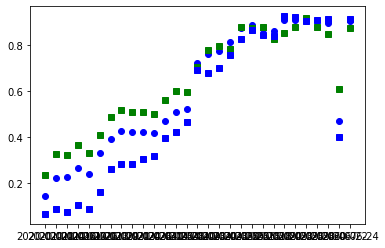

In [11]:
plt.plot(tseries[0]['x'],tseries[0]['y'],'bo',tseries[2]['y'], 'gs', tseries[3]['y'], 'bs')

plt.show()

In [12]:
def getTimeseriesForPolygon(covId, polylist,
                            tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                            start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                            printURL=False):


    tsURL = tsvBaseURL + covId 
    # print(tsvURL)
    tsURL = tsURL +'/geometry'

    payload = {
            "type": "Feature",
            "geometry": {
            "type": "Polygon",
            "coordinates": [
            
                polylist
            
            ]
            }
        }


    payload['startDate'] = start.strftime('%Y-%m-%d')
    payload['endDate'] = end.strftime('%Y-%m-%d')
    if printURL:
        print(tsURL, payload)
    response=requests.post(url=tsURL,json=payload)
    print(response.status_code)
    if response.status_code==200:
        timeSeries = response.json()['results']   
        return(timeSeries)

In [13]:
polygon=[]

point = [3.65, 51.14]
polygon.append(point)
point = [3.66, 51.14]
polygon.append(point)
point = [3.66, 51.15]
polygon.append(point)
point = [3.65, 51.15]
polygon.append(point)
point = [3.65, 51.14]
polygon.append(point)
resultForPoly  = getTimeseriesForPolygon(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VV',polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,5,1),printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VV/geometry {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[3.65, 51.14], [3.66, 51.14], [3.66, 51.15], [3.65, 51.15], [3.65, 51.14]]]}, 'startDate': '2020-01-01', 'endDate': '2020-05-01'}
200


So, this does return a COHERENCE time series. Good. <br>
The start and end dates are not taken into account, for some reason<br>
Strange things: 
* the totalCount is not always the same 
* sometimes there are invalid data (which is strange, as it cannot be attributed to cloud cover...)


date       valid   total   ratio   avg
---------- ------  ------  ------  -----
2017-01-06 107880  107880  1.0000  0.461
2017-01-12 107880  107880  1.0000  0.450
2017-01-18 107880  107880  1.0000  0.323
2017-01-24 107880  107880  1.0000  0.480
2017-01-30 107880  107880  1.0000  0.487
2017-02-05 107880  107880  1.0000  0.508
2017-02-11 107880  107880  1.0000  0.568
2017-02-17 107880  107880  1.0000  0.593
2017-02-23 107880  107880  1.0000  0.401
2017-03-01 107880  107880  1.0000  0.438
2017-03-07 107880  107880  1.0000  0.513
2017-03-13 107880  107880  1.0000  0.405
2017-03-19 107880  107880  1.0000  0.408
2017-03-25 107880  107880  1.0000  0.494
2017-03-31 107880  107880  1.0000  0.519
2017-04-06 107880  107880  1.0000  0.420
2017-04-12 107880  107880  1.0000  0.402
2017-04-14 169952  172608  0.9846  0.368
2017-04-15 107880  107880  1.0000  0.443
2017-04-18 107880  107880  1.0000  0.402
2017-04-20 172576  172608  0.9998  0.381
2017-04-21 107880  107880  1.0000  0.451
2017-04-24 107880 

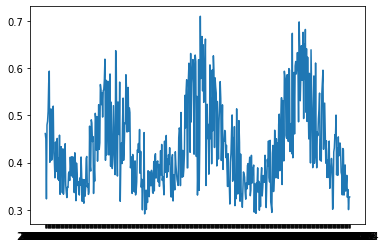

In [19]:
print('date       valid   total   ratio   avg')
print('---------- ------  ------  ------  -----')
x=[]
y=[]
for r in resultForPoly:

    if r['result']['validCount']>0:
        print(r['date'], '{0:6d} '.format(r['result']['validCount']),'{0:6d} '.format(r['result']['totalCount']), '{:.4f} '.format(r['result']['validCount']/r['result']['totalCount']), '{:.3f}'.format(r['result']['average']))
        x.append(r['date'])
        y.append(r['result']['average'])
        
plt.plot(x, y)

plt.show()

So, let's see if we can extract a time series for FAPAR<br>
Again, the start and end dates are not taken into account <br>
Here, the totalCount is constant. Notice it it just 21576 pixels to a lot more for coherence. How come?

In [20]:
resultForPoly2  = getTimeseriesForPolygon(covId='TERRASCOPE_S2_FAPAR_V2',polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,5,1),printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FAPAR_V2/geometry {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[3.65, 51.14], [3.66, 51.14], [3.66, 51.15], [3.65, 51.15], [3.65, 51.14]]]}, 'startDate': '2020-01-01', 'endDate': '2020-05-01'}
200


date       valid   total   ratio   avg
---------- ------  ------  ------  -----
2015-07-06  20566   21576  0.9532  0.570
2015-07-16  21576   21576  1.0000  0.586
2015-07-29  10927   21576  0.5064  0.516
2015-08-18     65   21576  0.0030  0.304
2015-08-28   9012   21576  0.4177  0.405
2015-11-13   1643   21576  0.0761  0.327
2015-11-26   5922   21576  0.2745  0.628
2015-12-03  21260   21576  0.9854  0.546
2015-12-23  13789   21576  0.6391  0.604
2016-01-02  19124   21576  0.8864  0.535
2016-01-12   8643   21576  0.4006  0.377
2016-01-25  20752   21576  0.9618  0.616
2016-03-12  21576   21576  1.0000  0.535
2016-03-15  21563   21576  0.9994  0.502
2016-03-22   9895   21576  0.4586  0.242
2016-03-25  17634   21576  0.8173  0.455
2016-04-01  21345   21576  0.9893  0.571
2016-04-04  20997   21576  0.9732  0.525
2016-04-14  20997   21576  0.9732  0.462
2016-04-24   2557   21576  0.1185  0.493
2016-05-01  21227   21576  0.9838  0.588
2016-05-04  21250   21576  0.9849  0.590
2016-05-11  20492 

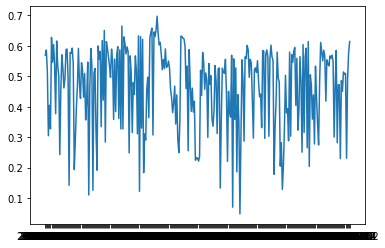

In [21]:
print('date       valid   total   ratio   avg')
print('---------- ------  ------  ------  -----')
x=[]
y=[]
for r in resultForPoly2:

    if r['result']['validCount']>0:
        print(r['date'], '{0:6d} '.format(r['result']['validCount']),'{0:6d} '.format(r['result']['totalCount']), '{:.4f} '.format(r['result']['validCount']/r['result']['totalCount']), '{:.3f}'.format(r['result']['average']))
        x.append(r['date'])
        y.append(r['result']['average'])
        
plt.plot(x, y)

plt.show()